In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# split data

In [2]:
import os
import random
from glob import glob
from shutil import rmtree, copyfile

labels = [s.split('/')[1] for s in glob('data/*')]
rmtree('training', ignore_errors=True)
rmtree('validation', ignore_errors=True)
random.seed(1024)
for label in labels:
    jpgs = glob('data/'+label+'/*.jpg')
    random.shuffle(jpgs)
    l = len(jpgs)//5
    os.makedirs('training/'+label)
    for jpg in jpgs[l:]:
        copyfile(jpg, 'training/'+label+'/'+os.path.basename(jpg))
    os.makedirs('validation/'+label)
    for jpg in jpgs[:l]:
        copyfile(jpg, 'validation/'+label+'/'+os.path.basename(jpg))

# basic VGG

In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout
from keras.layers.convolutional import ZeroPadding2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
def preprocessing(img):
    img = img - VGG_MEAN
    return img

model = Sequential()
model.add(Lambda(preprocessing, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
# Layer 1
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))
model.load_weights('vgg16_bn_tf.h5')

model.pop()
for layer in model.layers:
    layer.trainable=False
model.add(Dense(8, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [5]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [6]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, 
                                   target_size=target_size, 
                                   class_mode=class_mode, 
                                   shuffle=shuffle, 
                                   batch_size=batch_size)
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    classes = batches.classes
    filenames = batches.filenames
    return np.concatenate([batches.next() for i in range(batches.samples)]), classes, onehot(classes), filenames

In [7]:
training_batches = get_batches('training', batch_size=64)
validation_batches = get_batches('validation', batch_size=64*2, shuffle=False)

Found 3025 images belonging to 8 classes.
Found 752 images belonging to 8 classes.


In [8]:
trn, trn_classes, trn_labels, trn_filenames = get_data('training')
val, val_classes, val_labels, val_filenames = get_data('validation')

Found 3025 images belonging to 8 classes.
Found 752 images belonging to 8 classes.


In [9]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [10]:
save_array('trn.dat', trn)
save_array('val.dat', val)
save_array('trn_labels.dat', trn_labels)
save_array('val_labels.dat', val_labels)

In [11]:
trn = load_array('trn.dat')
val = load_array('val.dat')
trn_labels = load_array('trn_labels.dat')
val_labels = load_array('val_labels.dat')

In [12]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(trn, trn_labels, batch_size=64, epochs=3, validation_data=(val, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/3
3025/3025 [==============================] - 256s - loss: 3.0175 - acc: 0.4486 - val_loss: 1.6729 - val_acc: 0.6436
Epoch 2/3
3025/3025 [==============================] - 67s - loss: 1.6646 - acc: 0.6337 - val_loss: 0.9068 - val_acc: 0.7806
Epoch 3/3
3025/3025 [==============================] - 67s - loss: 1.3362 - acc: 0.6965 - val_loss: 0.7397 - val_acc: 0.8112


In [14]:
model.save_weights('ft1.h5')

## precompute conv output

In [15]:
layer_idx = [index for index, layer in enumerate(model.layers) if type(layer) is Conv2D][-1]
conv_layers, fc_layers = model.layers[:layer_idx+1], model.layers[layer_idx+1:]

In [16]:
conv_model = Sequential(conv_layers)

In [17]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [18]:
save_array('conv_feat.dat', conv_feat)
save_array('conv_val_feat.dat', conv_val_feat)

In [19]:
conv_feat = load_array('conv_feat.dat')
conv_val_feat = load_array('conv_val_feat.dat')

In [20]:
conv_val_feat.shape

(752, 512, 14, 14)

## train model

In [21]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

bn_model = Sequential(get_bn_layers(0.6))

In [22]:
bn_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
bn_model.fit(conv_feat, trn_labels, batch_size=64, epochs=10, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 3s - loss: 1.1478 - acc: 0.6810 - val_loss: 0.9868 - val_acc: 0.8378
Epoch 2/10
3025/3025 [==============================] - 2s - loss: 0.3290 - acc: 0.9068 - val_loss: 0.2889 - val_acc: 0.9282
Epoch 3/10
3025/3025 [==============================] - 2s - loss: 0.1721 - acc: 0.9464 - val_loss: 0.2147 - val_acc: 0.9441
Epoch 4/10
3025/3025 [==============================] - 2s - loss: 0.1207 - acc: 0.9623 - val_loss: 0.1396 - val_acc: 0.9721
Epoch 5/10
3025/3025 [==============================] - 2s - loss: 0.0834 - acc: 0.9765 - val_loss: 0.1580 - val_acc: 0.9721
Epoch 6/10
3025/3025 [==============================] - 2s - loss: 0.0477 - acc: 0.9891 - val_loss: 0.1284 - val_acc: 0.9707
Epoch 7/10
3025/3025 [==============================] - 2s - loss: 0.0494 - acc: 0.9845 - val_loss: 0.1142 - val_acc: 0.98010.984 - ETA: 0s - loss: 0.0497 - acc: 0.984
Epoch 8/10
3025/3025 [=============

In [24]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=64, epochs=10, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 2s - loss: 0.0328 - acc: 0.9907 - val_loss: 0.1610 - val_acc: 0.9681
Epoch 2/10
3025/3025 [==============================] - 2s - loss: 0.0161 - acc: 0.9964 - val_loss: 0.1481 - val_acc: 0.9694
Epoch 3/10
3025/3025 [==============================] - 2s - loss: 0.0274 - acc: 0.9921 - val_loss: 0.1509 - val_acc: 0.9694
Epoch 4/10
3025/3025 [==============================] - 2s - loss: 0.0261 - acc: 0.9940 - val_loss: 0.1642 - val_acc: 0.9668
Epoch 5/10
3025/3025 [==============================] - 2s - loss: 0.0261 - acc: 0.9934 - val_loss: 0.1782 - val_acc: 0.9721
Epoch 6/10
3025/3025 [==============================] - 2s - loss: 0.0247 - acc: 0.9924 - val_loss: 0.1563 - val_acc: 0.9707
Epoch 7/10
3025/3025 [==============================] - 2s - loss: 0.0165 - acc: 0.9947 - val_loss: 0.1781 - val_acc: 0.9668
Epoch 8/10
3025/3025 [==============================] - 2s - loss: 0.0209 - ac

In [25]:
bn_model.save_weights('conv_512_6.h5')

In [26]:
bn_model.load_weights('conv_512_6.h5')

## multi input, add image_size as input

In [27]:
import PIL

In [28]:
sizes = [PIL.Image.open('training/'+f).size for f in trn_filenames]
id2size = list(set(sizes))
size2id = {o:i for i, o in enumerate(id2size)}
{i:sizes.count(i) for i in id2size}

{(1192, 670): 162,
 (1244, 700): 21,
 (1276, 718): 184,
 (1280, 720): 1718,
 (1280, 750): 485,
 (1280, 924): 52,
 (1280, 974): 319,
 (1334, 750): 25,
 (1518, 854): 30,
 (1732, 974): 29}

In [29]:
from keras.utils.np_utils import to_categorical

trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
trn_sizes_orig

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [30]:
val_sizes = [PIL.Image.open('validation/'+f).size for f in val_filenames]
val_sizes_orig = to_categorical([size2id[o] for o in val_sizes], len(id2size))
val_sizes_orig

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [31]:
# one hot encoding, then normalization
trn_sizes = trn_sizes_orig - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)
val_sizes = val_sizes_orig - trn_sizes_orig.mean(axis=0) / trn_sizes_orig.std(axis=0)
trn_sizes

array([[-0.1322526 ,  0.5630276 , -0.34334557, ..., -1.14649928,
        -0.25449151, -0.10008344],
       [-0.1322526 , -0.4369724 , -0.34334557, ..., -0.14649928,
        -0.25449151, -0.10008344],
       [-0.1322526 , -0.4369724 , -0.34334557, ..., -0.14649928,
        -0.25449151, -0.10008344],
       ..., 
       [-0.1322526 , -0.4369724 ,  0.65665443, ..., -1.14649928,
        -0.25449151, -0.10008344],
       [-0.1322526 , -0.4369724 , -0.34334557, ..., -0.14649928,
        -0.25449151, -0.10008344],
       [-0.1322526 , -0.4369724 , -0.34334557, ..., -0.14649928,
        -0.25449151, -0.10008344]])

In [32]:
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model

inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

p = 0.6
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = concatenate([x,bn_inp])
x = Dense(8, activation='softmax')(x)

model = Model([inp, sz_inp], x)
model.summary()
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 14, 14)   0                                            
____________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)   (None, 512, 7, 7)     0           input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_7 (BatchNorm (None, 512, 7, 7)     2048        max_pooling2d_7[0][0]            
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 512, 7, 7)     0           batch_normalization_7[0][0]      
___________________________________________________________________________________________

In [33]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=64, epochs=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/3
3025/3025 [==============================] - 3s - loss: 1.1669 - acc: 0.6575 - val_loss: 0.8001 - val_acc: 0.8537
Epoch 2/3
3025/3025 [==============================] - 2s - loss: 0.3389 - acc: 0.9074 - val_loss: 0.2769 - val_acc: 0.9255
Epoch 3/3
3025/3025 [==============================] - 2s - loss: 0.1707 - acc: 0.9540 - val_loss: 0.1976 - val_acc: 0.9535


In [34]:
bn_model.fit(conv_feat, trn_labels, batch_size=64, epochs=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/8
3025/3025 [==============================] - 2s - loss: 0.0317 - acc: 0.9914 - val_loss: 0.2183 - val_acc: 0.9681
Epoch 2/8
3025/3025 [==============================] - 2s - loss: 0.0137 - acc: 0.9967 - val_loss: 0.2353 - val_acc: 0.9654
Epoch 3/8
3025/3025 [==============================] - 2s - loss: 0.0288 - acc: 0.9921 - val_loss: 0.1738 - val_acc: 0.9734
Epoch 4/8
3025/3025 [==============================] - 2s - loss: 0.0136 - acc: 0.9957 - val_loss: 0.2073 - val_acc: 0.9654
Epoch 5/8
3025/3025 [==============================] - 2s - loss: 0.0158 - acc: 0.9960 - val_loss: 0.1481 - val_acc: 0.9761
Epoch 6/8
3025/3025 [==============================] - 2s - loss: 0.0244 - acc: 0.9937 - val_loss: 0.2070 - val_acc: 0.9707
Epoch 7/8
3025/3025 [==============================] - 2s - loss: 0.0265 - acc: 0.9907 - val_loss: 0.1617 - val_acc: 0.9761
Epoch 8/8
3025/3025 [==============================] - 2s - loss: 0.0298 - acc: 0.991

In [35]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(conv_feat, trn_labels, batch_size=64, epochs=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/8
3025/3025 [==============================] - 2s - loss: 0.0231 - acc: 0.9927 - val_loss: 0.1855 - val_acc: 0.9694
Epoch 2/8
3025/3025 [==============================] - 2s - loss: 0.0135 - acc: 0.9964 - val_loss: 0.1821 - val_acc: 0.9681
Epoch 3/8
3025/3025 [==============================] - 2s - loss: 0.0091 - acc: 0.9970 - val_loss: 0.1818 - val_acc: 0.9707
Epoch 4/8
3025/3025 [==============================] - 2s - loss: 0.0080 - acc: 0.9990 - val_loss: 0.1790 - val_acc: 0.9734
Epoch 5/8
3025/3025 [==============================] - 2s - loss: 0.0230 - acc: 0.9937 - val_loss: 0.2014 - val_acc: 0.9694
Epoch 6/8
3025/3025 [==============================] - 2s - loss: 0.0122 - acc: 0.9954 - val_loss: 0.1912 - val_acc: 0.9734
Epoch 7/8
3025/3025 [==============================] - 2s - loss: 0.0154 - acc: 0.9944 - val_loss: 0.1835 - val_acc: 0.9681
Epoch 8/8
3025/3025 [==============================] - 2s - loss: 0.0145 - acc: 0.995

## multi output, bounding boxes

In [36]:
import json

In [37]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [97]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('annos/{}_labels.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[os.path.basename(l['filename'])] = sorted(l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [99]:
bb_json['img_04908.jpg']

In [100]:
trn_file2idx = {os.path.basename(o):i for i,o in enumerate(trn_filenames)}
val_file2idx = {os.path.basename(o):i for i,o in enumerate(val_filenames)}
for filename in trn_filenames + val_filenames:
    if os.path.basename(filename) not in bb_json:
        bb_json[os.path.basename(filename)] = {'height':0., 'width':0., 'x':0., 'y':0.}

In [59]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [60]:
trn_sizes = {os.path.basename(f):PIL.Image.open('training/'+f).size for f in trn_filenames}
val_sizes = {os.path.basename(f):PIL.Image.open('validation/'+f).size for f in val_filenames}

In [101]:
trn_bbox = np.stack([convert_bb(bb_json[os.path.basename(f)], trn_sizes[os.path.basename(f)]) for f in trn_filenames]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[os.path.basename(f)], val_sizes[os.path.basename(f)]) for f in val_filenames]).astype(np.float32)

[ 37.94723129  19.9488945   49.87223816  74.12122345]
(224, 224, 3)


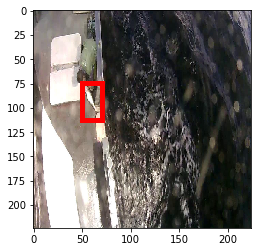

In [104]:
import matplotlib.pyplot as plt

def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=5)

def show_bb(i):
    bb = val_bbox[i]
    print(bb)
    plt.imshow(np.rollaxis(val[i], 0, 3).astype(np.uint8))
    print(np.rollaxis(val[i], 0, 3).astype(np.uint8).shape)
    plt.gca().add_patch(create_rect(bb))
    
show_bb(20)

## train

In [105]:
p = 0.6

inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

model = Model([inp], [x_bb, x_class])
model.compile(Adam(), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'], loss_weights=[.001, 1.])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 512, 14, 14)   0                                            
____________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)   (None, 512, 7, 7)     0           input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_10 (BatchNor (None, 512, 7, 7)     2048        max_pooling2d_8[0][0]            
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 512, 7, 7)     0           batch_normalization_10[0][0]     
___________________________________________________________________________________________

In [107]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=64, epochs=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 2s - loss: 3.4183 - bb_loss: 3288.5815 - class_loss: 0.1297 - bb_acc: 0.5296 - class_acc: 0.9646 - val_loss: 2.7602 - val_bb_loss: 2543.8759 - val_class_loss: 0.2163 - val_bb_acc: 0.5824 - val_class_acc: 0.9548
Epoch 2/10
3025/3025 [==============================] - 2s - loss: 2.7572 - bb_loss: 2664.3762 - class_loss: 0.0928 - bb_acc: 0.5663 - class_acc: 0.9759 - val_loss: 2.3237 - val_bb_loss: 2146.9730 - val_class_loss: 0.1767 - val_bb_acc: 0.5904 - val_class_acc: 0.9628
Epoch 3/10
3025/3025 [==============================] - 2s - loss: 2.0992 - bb_loss: 2031.3568 - class_loss: 0.0678 - bb_acc: 0.5964 - class_acc: 0.9792 - val_loss: 1.8351 - val_bb_loss: 1677.4071 - val_class_loss: 0.1576 - val_bb_acc: 0.6104 - val_class_acc: 0.9668
Epoch 4/10
3025/3025 [==============================] - 2s - loss: 1.4768 - bb_loss: 1425.4107 - class_loss: 0.0513 - bb_acc: 0.6334 - class_acc: 0.9851

In [108]:
model.fit(conv_feat, [trn_bbox, trn_labels], batch_size=64, epochs=20, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3025 samples, validate on 752 samples
Epoch 1/20
3025/3025 [==============================] - 2s - loss: 0.2512 - bb_loss: 233.9546 - class_loss: 0.0172 - bb_acc: 0.7398 - class_acc: 0.9960 - val_loss: 0.4099 - val_bb_loss: 238.8725 - val_class_loss: 0.1711 - val_bb_acc: 0.8125 - val_class_acc: 0.9707
Epoch 2/20
3025/3025 [==============================] - 2s - loss: 0.2421 - bb_loss: 229.6287 - class_loss: 0.0124 - bb_acc: 0.7445 - class_acc: 0.9964 - val_loss: 0.3846 - val_bb_loss: 226.8941 - val_class_loss: 0.1577 - val_bb_acc: 0.7832 - val_class_acc: 0.9734
Epoch 3/20
3025/3025 [==============================] - 2s - loss: 0.2348 - bb_loss: 209.8619 - class_loss: 0.0249 - bb_acc: 0.7451 - class_acc: 0.9927 - val_loss: 0.3835 - val_bb_loss: 215.2572 - val_class_loss: 0.1682 - val_bb_acc: 0.7633 - val_class_acc: 0.9721
Epoch 4/20
3025/3025 [==============================] - 2s - loss: 0.2276 - bb_loss: 211.1126 - class_loss: 0.0165 - bb_acc: 0.7362 - class_acc: 0.9947 - val_

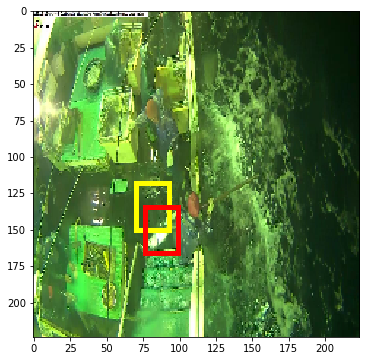

In [111]:
pred = model.predict(conv_val_feat[0:10])
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plt.imshow(np.rollaxis(val[i], 0, 3).astype(np.uint8))
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

show_bb_pred(3)

In [112]:
model.save_weights('bn_anno.h5')
model.load_weights('bn_anno.h5')